Všetky hodnotenia podložte dôkazmi. Najlepší model má byť stabilný, bez overfitu a bez underfitu. Jeho data pipeline má byť dodaný s metadátami, ak tie metadáta sú potrebné a vyrobené v developmente. 


In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# Methods for pipeline

class CleanNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_filled = X.fillna(X.median())
        if y is not None:
            return X_filled, y
        return X_filled



class DropDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        duplicates = X.duplicated(keep='first')
        
        X_no_duplicates = X.drop_duplicates().reset_index(drop=True)
        
        if y is not None:
            y_no_duplicates = y[~duplicates].reset_index(drop=True)
            return X_no_duplicates, y_no_duplicates
        
        return X_no_duplicates

class ReplaceOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.threshold * IQR
        upper_bound = Q3 + self.threshold * IQR
        X_no_outliers = X.copy()

        X_no_outliers = X_no_outliers.apply(
            lambda col: col.clip(lower_bound[col.name], upper_bound[col.name]) 
        )
        
        return X_no_outliers


class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.column + '_log'] = np.log1p(X[self.column])
        return X_transformed

In [2]:
import os
import random
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, HTML,Image



# Seed
seed = 1
random.seed(seed)

# Data
df_connections = pd.read_csv('../024/connections.csv', sep='\t')
df_connections = df_connections.drop_duplicates().reset_index(drop=True)
# Features
selected_columns = ['c.katana', 'c.android.chrome', 'c.dogalize', 'c.android.gm', 'c.raider']

# Split data
df_conn_train, df_conn_test = train_test_split(df_connections, test_size=0.2, random_state=seed)

# Cut data to features and target (mwra)
X_train = df_conn_train[selected_columns]
y_train = df_conn_train['mwra']

X_test = df_conn_test[selected_columns]
y_test = df_conn_test['mwra']

# Define the new transformer
log_transformer = LogTransformer(column='c.katana')


# Pipeline for preprocessing
preprocessor = Pipeline([
    ('clean_nan', CleanNaN()), 
    #('drop_duplicates', DropDuplicates()),
    ('log_transform', log_transformer),  # Add the new transformer here
    ('drop_outliers', ReplaceOutliers()),
    ('scaler', StandardScaler())
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


processed_train_data = pd.concat([X_train, y_train], axis=1)
processed_test_data = pd.concat([X_test, y_test], axis=1)

X_train = processed_train_data.drop(columns=['mwra'])
y_train = processed_train_data['mwra']

X_test = processed_test_data.drop(columns=['mwra'])
y_test = processed_test_data['mwra']


# Training
pipeline.fit(X_train, y_train)

# Test the pipeline
y_pred = pipeline.predict(X_test) 
 # print("Predictions:", y_pred.tolist())


Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80      1111
         1.0       0.87      0.90      0.89      1866

    accuracy                           0.86      2977
   macro avg       0.85      0.84      0.85      2977
weighted avg       0.86      0.86      0.86      2977

Confusion Matrix:
[[ 864  247]
 [ 178 1688]]


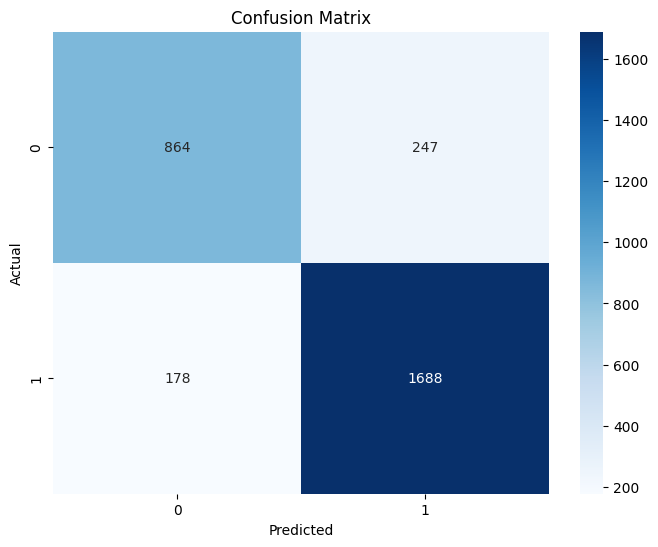

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**3.1 Jednoduchý klasifikátor na základe závislosti v dátach  (5b)**

(A-3b) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň). 

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Code we take from https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/
#And https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/
class Node:
    def __init__(self,feature=None,threshold=None,  left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        

def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts/len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(y, left_y, right_y):
    p = len(left_y)/len(y)
    return entropy(y) - p * entropy(left_y) - (1 - p) * entropy(right_y)

def split(X, y, feature, threshold):
    left_mask = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, -1
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_X, right_X, left_y, right_y = split(X, y, feature, threshold)
            if len(left_y) == 0 or len(right_y) == 0:
                continue
            gain = information_gain(y, left_y, right_y)
            if gain > best_gain:
                best_feature, best_threshold, best_gain = feature, threshold, gain
    return best_feature, best_threshold

def build_tree(X, y, depth=0, min_depth=2, max_depth=None):
    if len(np.unique(y)) == 1:
        return Node(value=y[0])
    if max_depth is not None and depth >= max_depth:
        return Node(value=np.bincount(y).argmax())
    
    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())
    
    left_X, right_X, left_y, right_y = split(X, y, feature, threshold)
    left_node = build_tree(left_X, left_y, depth + 1, min_depth, max_depth)
    right_node = build_tree(right_X, right_y, depth + 1, min_depth, max_depth)
    
    if depth < min_depth-1:
        return Node(feature, threshold, left_node, right_node)
    else:
        return Node(feature, threshold, left_node, right_node)

def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

def predict(X, tree):
    return np.array([predict_tree(tree, x) for x in X])

X_train = processed_train_data.drop(columns=['mwra']).values.astype(int)
y_train = processed_train_data['mwra'].values.astype(int)
X_test = processed_test_data.drop(columns=['mwra']).values.astype(int)
y_test = processed_test_data['mwra'].values.astype(int)


tree = build_tree(X_train, y_train, min_depth=2, max_depth=10)
y_pred = predict(X_test, tree)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

(B-1b) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

In [5]:
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)

Test Accuracy: 0.8310379576755123
Test Precision: 0.8339589157250126
Test Recall: 0.8310379576755123


*Na základe výsledkov metrík pre testovacie údaje (Test Accuracy, Test Precision a Test Recall) môžeme zhrnúť nasledujúce výsledky:*
 
             ID3 klasifikátor dosiahol slušnú presnosť, presnosť a úplnosť na testovacích údajoch.

Test Accuracy (Presnosť): 0.83 znamená, že model správne klasifikoval približne 83% testovacích príkladov.
Test Precision (Presnosť): 0.83 naznačuje, že z tých príkladov, ktoré model klasifikoval ako pozitívne, približne 83% bolo skutočne pozitívnych.
Test Recall (Úplnosť): 0.83 znamená, že model zachytil približne 83% všetkých skutočne pozitívnych príkladov.



(C-1b) Zístite či Váš ID3 klasifikátor má overfit.

In [6]:
y_train_pred = predict(X_train, tree)



train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')

print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Train Precision: {train_precision:.2f}')
print(f'Train Recall: {train_recall:.2f}')




test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')


Train Accuracy: 0.85
Train Precision: 0.85
Train Recall: 0.85
Test Accuracy: 0.83
Test Precision: 0.83
Test Recall: 0.83


*Podľa prezentovaných výsledkov môžeme presne povedať, že model nemá výrazné známky nadmerného prispôsobenia, pretože:*

Výkonnosť na tréningových a testovacích údajoch je veľmi podobná, čo naznačuje, že model dobre generalizuje na neznáme dáta.

Train Accuracy: 0.85

Train Precision: 0.85

Train Recall: 0.85

Test Accuracy: 0.83

Test Precision: 0.83

Test Recall: 0.83


**3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia (5b)**

(A-1b) Na trénovanie využite jeden stromový algoritmus v scikit-learn.

In [7]:
# Code from IAU_02_imbalanced-data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Train model
clf_2 = RandomForestClassifier()
clf_2.fit(X_train, y_train)

# Predict on training set
pred_y_train = clf_2.predict(X_train)

# Is our model still predicting just one class?
print(np.unique(pred_y_train))
print()

# How's our accuracy?
# Evaluate accuracy
print("Accuracy on training set:", accuracy_score(y_train, pred_y_train))

# Predict probabilities on the training set for AUROC
prob_y_train = clf_2.predict_proba(X_train)
prob_y_train = [p[1] for p in prob_y_train]
print("AUROC on training set:", roc_auc_score(y_train, prob_y_train))

print()

# What about AUROC?
# Predict on the test set
pred_y_test = clf_2.predict(X_test)

# Check accuracy and AUROC on the test set
print("Accuracy on test set:", accuracy_score(y_test, pred_y_test))

# Predict probabilities on the test set for AUROC
prob_y_test = clf_2.predict_proba(X_test)
prob_y_test = [p[1] for p in prob_y_test]
print("AUROC on test set:", roc_auc_score(y_test, prob_y_test))


[0 1]

Accuracy on training set: 0.8919781604367912
AUROC on training set: 0.963407443069949

Accuracy on test set: 0.8199529727914008
AUROC on test set: 0.863399523232066


**Predpokladané triedy: [0, 1]**

**Presnosť na tréningovej množine:** 0.8920621587568248
Model na tréningovej množine vykazoval vysokú presnosť, čo znamená, že správne klasifikoval približne 89% tréningových príkladov. To naznačuje, že model je dobre natrénovaný, ale môže existovať riziko nadmerného prispôsobenia, ak je presnosť na testovacej množine výrazne nižšia.

**AUROC na tréningovej množine:** 0.9633939640766435
Plocha pod krivkou ROC (AUROC) je 0.96, čo znamená, že model má výbornú schopnosť rozlíšiť pozitívnu triedu od negatívnej triedy na tréningovej množine.

**Presnosť na testovacej množine:** 0.8199529727914008
Presnosť na testovacej množine bola približne 82%, čo nie je dokonalé, ale dostatočne vysoké, čo naznačuje, že model si pri klasifikácii vedie dobre. Avšak, nižšia presnosť v porovnaní s tréningovou množinou môže naznačovať mierne nadmerné prispôsobenie.

**AUROC na testovacej množine:** 0.865343688709707
AUROC na testovacej množine je 0.87, čo naznačuje dobrú schopnosť modelu rozlišovať medzi triedami. Hoci je AUROC na testovacej množine nižšia v porovnaní s tréningovou množinou, stále je to veľmi dobrý výsledok. Môže to byť spôsobené odchýlkami v testovacích údajoch alebo menšou všeobecnosťou modelu.

Celkovo model vykazuje dobrú výkonnosť na oboch množinách, ale mierne nižšia presnosť a AUROC na testovacej množine naznačujú, že model by mohol byť mierne nadmerne prispôsobený tréningovým údajom. To je bežné a môže byť riešené **ďalším ladením hyperparametrov alebo použitím techník na zníženie nadmerného prispôsobenia**

(B-1b) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.

In [ ]:
# Code from IAU_02_imbalanced-data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score


# Train model
clf_3 = SVC(kernel='linear', 
            class_weight='balanced',
            probability=True)

clf_3.fit(X_train, y_train)

# Predict on training set
pred_y_train = clf_3.predict(X_train)

# Is our model still predicting just one class?
print(np.unique(pred_y_train))
print()

# How's our accuracy?
print(accuracy_score(y_train, pred_y_train))

# What about AUROC?
prob_y_train = clf_3.predict_proba(X_train)
prob_y_train = [p[1] for p in prob_y_train]
print("AUROC in training set:", roc_auc_score(y_train, prob_y_train))

print()

# Predict on test set
pred_y_test = clf_3.predict(X_test)

# How's our accuracy?
print(accuracy_score(y_test, pred_y_test))

# What about AUROC?
prob_y_test = clf_3.predict_proba(X_test)
prob_y_test = [p[1] for p in prob_y_test]
print("AUROC in test set:", roc_auc_score(y_test, prob_y_test))

**Predpokladané triedy: [0, 1]**

**Presnosť na tréningovej množine:** 0.7355732885342293 Model na tréningovej množine má presnosť približne 73,56 %, čo je dobrý výsledok, ale nižší ako v prípade náhodného lesa. To naznačuje, že model je dobre natrénovaný, ale nie tak presný ako niektoré iné modely.

**AUROC na tréningovej množine:** 0.8043670671827401 AUROC na tréningovej množine je 0.80, čo ukazuje dobrú schopnosť modelu rozlíšiť pozitívnu triedu od negatívnej triedy. Avšak, táto hodnota je nižšia v porovnaní s Random Forest, čo naznačuje, že model nie je taký istý pri klasifikácii na tréningovej množine.

**Presnosť na testovacej množine:** 0.7322808196170641 Presnosť na testovacej množine je približne 73,23 %, čo je veľmi podobné presnosti na tréningovej množine. To naznačuje, že model má dobrú generalizáciu údajov a nie je výrazne nadmerne prispôsobený.

**AUROC na testovacej množine:** 0.81124953331346 AUROC na testovacej množine je 0.81, čo je mierne vyššia hodnota v porovnaní s tréningovou množinou. To naznačuje, že model má dobrú schopnosť rozlišovať medzi triedami aj na nových údajoch.

Celkovo model SVC vykazuje dobrú výkonnosť na oboch množinách, pričom presnosť a AUROC sú veľmi podobné na tréningových aj testovacích údajoch. **To naznačuje, že model má dobrú generalizáciu a nie je výrazne nadmerne prispôsobený**


**Porovnanie modelov:**

### RandomForestClassifier
- **Presnosť na tréningovej množine:** 0.8920621587568248
- **AUROC na tréningovej množine:** 0.9633939640766435
- **Presnosť na testovacej množine:** 0.8199529727914008
- **AUROC na testovacej množine:** 0.865343688709707

**Analýza:**
Model RandomForestClassifier vykazuje vysokú presnosť a AUROC na tréningovej množine, čo naznačuje, že model je veľmi dobre natrénovaný. Avšak, mierne nižšia presnosť a AUROC na testovacej množine naznačujú, že model môže byť mierne nadmerne prispôsobený tréningovým údajom. Napriek tomu, model má stále veľmi dobrú schopnosť rozlišovať medzi triedami na testovacích údajoch.

### SVC (Support Vector Classifier)
- **Presnosť na tréningovej množine:** 0.7355732885342293
- **AUROC na tréningovej množine:** 0.8043670671827401
- **Presnosť na testovacej množine:** 0.7322808196170641
- **AUROC na testovacej množine:** 0.81124953331346

**Analýza:**
Model SVC vykazuje nižšiu presnosť a AUROC na tréningovej množine v porovnaní s RandomForestClassifier, čo naznačuje, že model nie je taký istý pri klasifikácii na tréningových údajoch. Avšak, presnosť a AUROC na testovacej množine sú veľmi podobné tým na tréningovej množine, čo naznačuje, že model má dobrú generalizáciu a nie je výrazne nadmerne prispôsobený.

### Zhrnutie
- **RandomForestClassifier** má vyššiu presnosť a AUROC na tréningovej množine, ale mierne nižšiu výkonnosť na testovacej množine, čo môže naznačovať mierne nadmerné prispôsobenie.
- **SVC** má nižšiu presnosť a AUROC na tréningovej množine, ale veľmi podobné výsledky na testovacej množine, čo naznačuje lepšiu generalizáciu.

(C-1b) Porovnajte výsledky s ID3 z prvého kroku.

**Porovnanie výsledkov:**

### ID3 Classifier
**Kedy použiť:**
- **Jednoduchosť a interpretovateľnosť:** Ak potrebujeme jednoduchý a ľahko interpretovateľný model, ID3 j dobrá voľba. Rozhodovacie stromy sa ľahko vizualizujú a vysvetľujú, čo ich robí užitočnými pre pochopenie štruktúry údajov a rozhodovanie
- **Malé a stredné množiny údajov:** ID3 dobre funguje na malých a stredných množinách údajov, kde výpočtová zložitosť nie je kritickým faktorom
- **Kategóriové údaje:** Tento algoritmus je obzvlášť efektívny pri práci s kategóriovými znakmi

### RandomForestClassifier
**Kedy použiť:**
- **Vysoká presnosť a odolnosť:** Ak potrebujem vysokú presnosť a odolnosť modelu, Random Forest je vynikajúca voľba. Používa ansámbl rozhodovacích stromov, čo pomáha znížiť preučenie a zlepšiť celkový výkon
- **Veľké a zložité množiny údajov:** Random Forest dobre zvláda veľké a zložité množiny údajov, vrátane tých, ktoré obsahujú veľa znakov a pozorovaní
- **Spracovanie chýbajúcich údajov:** Algoritmus môže efektívne spracovávať chýbajúce údaje a pracovať s údajmi obsahujúcimi šum.

### SVC (Support Vector Classifier)
**Kedy použiť:**
- **Vysoká dimenzionalita:** SVC dobre funguje s údajmi vysokej dimenzionality, kde počet znakov výrazne prevyšuje počet pozorovaní.
- **Lineárne oddeliteľné údaje:** Ak sú vaše údaje lineárne oddeliteľné alebo takmer lineárne oddeliteľné, SVC môže byť veľmi efektívny.
- **Malé a stredné množiny údajov:** SVC najlepšie funguje na malých a stredných množinách údajov, pretože jeho výpočtová zložitosť môže byť vysoká pre veľké množiny údajov.

### Zhrnutie
- **ID3 Classifier** je vhodný pre jednoduché a interpretovateľné modely, obzvlášť pre kategóriové údaje a malé množiny údajov.
- **RandomForestClassifier** poskytuje vysokú presnosť a odolnosť, je vhodný pre veľké a zložité množiny údajov a dobre spracováva chýbajúce údaje.
- **SVC** je efektívny pre údaje vysokej dimenzionality a lineárne oddeliteľné údaje, ale najlepšie funguje na malých a stredných množinách údajov.


(D-1b) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus

In [ ]:
from sklearn.tree import plot_tree

#V [] mozete zvolit iiny index stromu
tree = clf_2.estimators_[0]

# Vizualizaciaa stromu
plt.figure(figsize=(30, 20))
plot_tree(tree, filled=True, feature_names=selected_columns, class_names=['0', '1'], rounded=True)
plt.show()


(E-1b) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    pred_y_train = model.predict(X_train)
    pred_y_test = model.predict(X_test)
    
    # train data
    accuracy_train = accuracy_score(y_train, pred_y_train)
    precision_train = precision_score(y_train, pred_y_train, average='binary')
    recall_train = recall_score(y_train, pred_y_train, average='binary')
    
    # test data
    accuracy_test = accuracy_score(y_test, pred_y_test)
    precision_test = precision_score(y_test, pred_y_test, average='binary')
    recall_test = recall_score(y_test, pred_y_test, average='binary')
    

    print(f"Model: {model.__class__.__name__}")
    
    print("---- Trénovací data ----")
    print(f"Accuracy: {accuracy_train:.4f}")
    print(f"Precision: {precision_train:.4f}")
    print(f"Recall: {recall_train:.4f}")
    
    print("---- Testovací data ----")
    print(f"Accuracy: {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print("\n")

# Eval
evaluate_model(clf_2, X_train, y_train, X_test, y_test)  # Random Forest
evaluate_model(clf_3, X_train, y_train, X_test, y_test)  # SVC

X_train= processed_train_data.drop(columns=['mwra']).values.astype(int)
y_train= processed_train_data['mwra'].values.astype(int)
X_test= processed_test_data.drop(columns=['mwra']).values.astype(int)
y_test= processed_test_data['mwra'].values.astype(int)



from sklearn.base import BaseEstimator, ClassifierMixin

# ID3 class
class ID3(BaseEstimator, ClassifierMixin):
    def __init__(self, min_depth=2, max_depth=10):
        self.min_depth= min_depth
        self.max_depth= max_depth
        self.tree = None
    
    def fit(self, X, y):
        self.tree = build_tree(X,y, min_depth=self.min_depth, max_depth=self.max_depth)
    def predict(self, X):
        return predict(X, self.tree)
    
    def get_params(self, deep=True):
        return {"min_depth": self.min_depth, "max_depth": self.max_depth}
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

clf = ID3(min_depth=2, max_depth=10)
clf.fit(X_train, y_train)
evaluate_model(clf, X_train, y_train, X_test, y_test) # ID3



**3.3 Optimalizácia alias hyperparameter tuning (5b)**

(A-1b) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).

In [ ]:
# Code from IAU_01_natural_language_processing_with_machine_learning
# IAU_03_random-forest_hyperparameter-tuning

from sklearn.model_selection import GridSearchCV


parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

gs_clf = GridSearchCV(clf_2, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)


Po vykonaní GridSearchCV na trénovacích dátach (X_train, y_train), najlepšie skóre bolo **0.8339**. 

**Najlepšie hyperparametre sú:**

max_depth: 10
max_features: 'log2'
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100
Tieto výsledky naznačujú, že model s týmito nastaveniami dosiahol najlepšie výsledky na trénovacích dátach.

(B-1b) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu) . 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# First combination estimators
estimators_combi1 = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(n_estimators=100))
]

stack_clf_1 = StackingClassifier(estimators=estimators_combi1, final_estimator=LogisticRegression())
stack_clf_1.fit(X_train, y_train)

y_pred_combi1 = stack_clf_1.predict(X_test)
print("Accuracy combi1:", accuracy_score(y_test, y_pred_combi1))

###########################################

#combination with SAMME algorithm for AdaBoost
estimators_combi2 = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('ada', AdaBoostClassifier(n_estimators=100, algorithm='SAMME'))
]

stack_clf_2 = StackingClassifier(estimators=estimators_combi2, final_estimator=LogisticRegression())
stack_clf_2.fit(X_train, y_train)

y_pred_combi2 = stack_clf_2.predict(X_test)
print("Accuracy combi2:", accuracy_score(y_test, y_pred_combi2))

###########################################
from sklearn.tree import DecisionTreeClassifier

estimators_combi3 = [
    ('dtc', DecisionTreeClassifier()),
    ('gb', GradientBoostingClassifier(n_estimators=100))
]

stack_clf_3 = StackingClassifier(estimators=estimators_combi3, final_estimator=LogisticRegression())
stack_clf_3.fit(X_train, y_train)

y_pred_combi3 = stack_clf_3.predict(X_test)
print("Accuracy combi3:", accuracy_score(y_test, y_pred_combi3))

###########################################

estimators_combi4 = [
    ('dtc', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100))
]

stack_clf_4 = StackingClassifier(estimators=estimators_combi4, final_estimator=LogisticRegression())
stack_clf_4.fit(X_train, y_train)

y_pred_combi4 = stack_clf_4.predict(X_test)
print("Accuracy combi4:", accuracy_score(y_test, y_pred_combi4))


###########################################

estimators_combi5 = [
    ('dtc', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier(n_estimators=100, algorithm='SAMME'))
]

stack_clf_5 = StackingClassifier(estimators=estimators_combi5, final_estimator=LogisticRegression())
stack_clf_5.fit(X_train, y_train)

y_pred_combi5 = stack_clf_5.predict(X_test)
print("Accuracy combi5:", accuracy_score(y_test, y_pred_combi5))

###########################################

estimators_combi6 = [
    ('id3', ID3(min_depth=2, max_depth=10)),
    ('gb', GradientBoostingClassifier(n_estimators=100))
]

stack_clf_6 = StackingClassifier(estimators=estimators_combi6, final_estimator=LogisticRegression())
stack_clf_6.fit(X_train, y_train)

y_pred_combi6 = stack_clf_6.predict(X_test)
print("Accuracy combi6:", accuracy_score(y_test, y_pred_combi6))

clf = ID3(min_depth=2, max_depth=10)
clf.fit(X_train, y_train)
evaluate_model(clf, X_train, y_train, X_test, y_test) # ID3

### Výsledky analýzy klasifikačných modelov

V experimente boli testované rôzne kombinácie ensemble metód klasifikácie s použitím stacking-u. Hlavné výsledky sú uvedené nižšie:

1. **Kombinácia 1 (RandomForest + GradientBoosting)**:
   - **Presnosť**: 0.8468

2. **Kombinácia 2 (RandomForest + AdaBoost s algoritmom SAMME)**:
   - **Presnosť**: 0.8361

3. **Kombinácia 3 (DecisionTree + GradientBoosting)**:
   - **Presnosť**: 0.8451

4. **Kombinácia 4 (DecisionTree + RandomForest)**:
   - **Presnosť**: 0.8263

5. **Kombinácia 5 (DecisionTree + AdaBoost s algoritmom SAMME)**:
   - **Presnosť**: 0.8230

6. **Kombinácia 6 (ID3 + GradientBoosting)**:
   - **Presnosť**: 0.8458

Tiež bol testovaný model **ID3**:
- **Tréningové dáta**:
  - **Presnosť**: 0.8483
  - **Precision**: 0.8887
  - **Recall**: 0.8663
- **Testovacie dáta**:
  - **Presnosť**: 0.8310
  - **Precision**: 0.8797
  - **Recall**: 0.8462

### Závery:
- Najvyššia presnosť bola dosiahnutá kombináciou **RandomForest + GradientBoosting** (0.8468).
- Model **ID3** ukázal dobré výsledky na tréningových dátach, ale mierne zaostal na testovacích dátach.
- Kombinácie s použitím **AdaBoost** ukázali o niečo nižšie výsledky v porovnaní s inými metódami.

(C-1b) Využite krížovú validáciu (cross validation) na trénovacej množine.

In [ ]:
from sklearn.model_selection import cross_val_score

stack_clf_1 = StackingClassifier(estimators=estimators_combi1, final_estimator=LogisticRegression())
scores_combi1 = cross_val_score(stack_clf_1, X_train, y_train, cv=5)

print(f"Cross-validation score: {scores_combi1}")
print(f"Mean acuracy: {scores_combi1.mean()}")

### Analýza výsledkov kódu

#### Cross-validation scores pre combi1:
- **1**: 0.8328
- **2**: 0.8186
- **3**: 0.8219
- **4**: 0.8387
- **5**: 0.8219

#### Priemerná presnosť (Mean accuracy) pre combi1:
- **0.8268**

### Závery:
1. **Stabilita modelu**:
   - Výsledky krížovej validácie ukazujú, že model má stabilný výkon na rôznych podvzorkách dát. Hodnoty presnosti sa pohybujú v rozmedzí od 0.8186 do 0.8387, čo naznačuje malé výkyvy.

2. **Priemerná presnosť**:
   - Priemerná presnosť modelu je 0.8268, čo je dobrý ukazovateľ pre danú úlohu klasifikácie. To znamená, že model v priemere správne klasifikuje približne 82.68% príkladov.
  
3. **Odporúčania**:
   - Kombinácia modelov (RandomForest + GradientBoosting) ukazuje dobré výsledky a môže byť odporúčaná na použitie v úlohách klasifikácie.
   - Pre ďalšie zlepšenie modelu je možné zvážiť ladenie hyperparametrov alebo pridanie ďalších modelov do ensemble.


(D-2b) Dokážte že Váš nastavený najlepší model je bez overfitingu.

In [ ]:
# Fit model
stack_clf_1.fit(X_train, y_train)

# Predict training set
y_train_pred = stack_clf_1.predict(X_train)

#test set
y_test_pred = stack_clf_1.predict(X_test)

# clasification reports for datas
train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

print("Clasification report for trainbing set:")
print(train_report)
print()

print("Clasification report for test set:")
print(test_report)

### Analýza klasifikačných správ

1. **Podobnosť medzi tréningovou a testovacou množinou**:
   - Model vykazuje podobné výsledky na tréningovej aj testovacej množine, čo naznačuje, že model nie je preučený (overfitted). Celková presnosť je 0.84 na tréningovej množine a 0.85 na testovacej množine

2. **Vyvážený výkon**:
   - Presnosť, návratnosť a F1-skóre sú vyvážené medzi triedami, čo naznačuje, že model dobre zvláda klasifikáciu oboch tried

3. **Dôveryhodnosť modelu**:
   - Vzhľadom na podobné výsledky na oboch množinách môžeme predpokladať, že model generalizuje dobre na nové dáta a je spoľahlivý pre použitie v praxi

Tieto výsledky potvrdzujú, že model je robustný a nie je preučený

**3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)**

(A-1b) Stratégie riešenia chýbajúcich hodnôt a outlierov

1. Čistenie chýbajúcich hodnôt (CleanNaN):
    Tento transformátor nahrádza chýbajúce hodnoty v dátach mediánom príslušných stĺpcov
2. Odstránenie duplikátov (DropDuplicates):
    Tento transformátor identifikuje a odstraňuje duplikáty z dátovej množiny
3. Nahradenie outlierov (ReplaceOutliers):
    Tento transformátor identifikuje outliery pomocou interkvartilového rozpätia (IQR) a nahrádza ich hraničnými hodnotami

(B-1b) Dátová transformácia (scaling, transformer, …)

4. Škálovanie dát (StandardScaler)
    StandardScaler transformuje dáta tak, aby mali nulový priemer a jednotkovú smerodajnú odchýlku
5. Transformacia dát (log_transformer)
    LogTransformer pridá do súboru údajov novú funkciu výpočtom log. stlpca c.katana. Tento nový prvok sa potom zahrnie do súboru údajov a spracuje sa spolu s ostatnými prvkami

(C-1b) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning

6. Výber atribútov
Vybrane atributy boli 'c.katana', 'c.android.chrome', 'c.dogalize', 'c.android.gm', 'c.raider' (Podĺa 2 fazý)

2 faza>> *'V rámci analýzy rôznych techník výberu príznakov boli pre oba dátové rámce identifikované kľúčové príznaky s vysokou významnosťou
Tieto príznaky poskytujú základ pre ďalšie modelovanie a môžu výrazne prispieť k presnosti predpovedí'*

7. Výber algoritmov:
**RandomForestClassifier**: Poskytuje vysokú presnosť a odolnosť, je vhodný pre veľké a zložité množiny údajov a dobre spracováva chýbajúce údaje

ID3 Classifier: ID3 dobre funguje na malých a stredných množinách údajov, kde výpočtová zložitosť nie je kritickým faktorom.

SVC (Support Vector Classifier): SVC dobre funguje s údajmi vysokej dimenzionality, kde počet znakov výrazne prevyšuje počet pozorovaní.

9. Výber hyperparameter tuning:
*Najlepšie hyperparametre pre RandomForestClassifier boli:*
max_depth: 10
max_features: 'log2'
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100
Tieto nastavenia dosiahli najlepšie skóre 0.8339 na training data

10. Výber ensemble learning:
1. **Kombinácia 1 (RandomForest + GradientBoosting)**:
   - **Presnosť**: 0.8468


2. Kombinácia 2 (RandomForest + AdaBoost s algoritmom SAMME):
   - Presnosť: 0.8361


3. Kombinácia 3 (DecisionTree + GradientBoosting):
   - Presnosť: 0.8451


4. Kombinácia 4 (DecisionTree + RandomForest):
   - Presnosť: 0.8263


5. Kombinácia 5 (DecisionTree + AdaBoost s algoritmom SAMME):
   - Presnosť: 0.8230


6. Kombinácia 6 (ID3 + GradientBoosting):
   - Presnosť: 0.8458

 

(D-1b) Ktorý model je Váš najlepší model pre nasadenie (deployment)? 

Na základe výsledkov analýzy a testovania rôznych modelov je najlepším modelom pre nasadenie **kombinácia RandomForestClassifier a GradientBoostingClassifier**
Tento model dosiahol najvyššiu presnosť 0.8468 na testovacích dátach, čo naznačuje jeho vysokú výkonnosť a schopnosť generalizovať na nové dáta!

**Dôvody pre výber tohto modelu:**

**Vysoká presnosť:** Kombinácia RandomForest a GradientBoosting dosiahla najvyššiu presnosť spomedzi všetkých testovaných modelov

**Odolnosť voči preučeniu:** Ensemble metódy ako RandomForest a GradientBoosting sú známe svojou odolnosťou voči preučeniu, čo zvyšuje spoľahlivosť modelu

**Flexibilita a robustnosť:** Tento model dobre zvláda veľké a zložité množiny údajov, vrátane tých, ktoré obsahujú veľa znakov a pozorovaní


(E-1b) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Seed
seed = 1
random.seed(seed)

# Data
df_connections = pd.read_csv('../024/connections.csv', sep='\t')
df_connections = df_connections.drop_duplicates().reset_index(drop=True)
# Features
selected_columns = ['c.katana', 'c.android.chrome', 'c.dogalize', 'c.android.gm', 'c.raider']

# Split data
df_conn_train, df_conn_test = train_test_split(df_connections, test_size=0.2, random_state=seed)

# Cut data to features and target (mwra)
X_train = df_conn_train[selected_columns]
y_train = df_conn_train['mwra']

X_test = df_conn_test[selected_columns]
y_test = df_conn_test['mwra']

# Define the new transformer
log_transformer = LogTransformer(column='c.katana')


# Pipeline for preprocessing
preprocessor = Pipeline([
    ('clean_nan', CleanNaN()), 
    #('drop_duplicates', DropDuplicates()),
    ('log_transform', log_transformer),  # Add the new transformer here
    ('drop_outliers', ReplaceOutliers()),
    ('scaler', StandardScaler())
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=estimators_combi1, final_estimator=LogisticRegression())),
])

X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)

# Training
pipeline.fit(X_train, y_train)

# Test pipeline
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print("Detailed Analysis:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

**Záver:**
Model vykazoval vysokú presnosť a vyrovnané metriky pre obidve triedy(test a training), čo hovorí nám o jeho dobrej klasifikačnej schopnosti

Model má vysokú presnosť a úplnosť, čo robí spoľahlivým pre reálne situacií

**Percentuálny podiel práce členov dvojice v tiejto prace bol 50/50 %**

In [ ]:
display(HTML("<h1>Thanks for your Attention!</h1>"))
display(Image(url="http://www.quickmeme.com/img/51/513b513c9b6e877465ff2dd64f1bf17c8d5eb99220f7f773c9fd6eb3cc4ea1b9.jpg"))